In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt


In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25


In [5]:
#Load Dataset 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Yam",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode = "int"
    
)
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

Found 515 files belonging to 3 classes.
(32, 256, 256, 3)
(32,)


In [6]:
class_names = dataset.class_names
print(class_names)

['bad_yam', 'good_yam', 'not_yam']


(256, 256, 3)
[2 0 0 0 0 2 2 1 1 2 0 2 1 1 2 0 0 2 2 0 0 1 1 1 0 0 0 1 0 0 2 2]


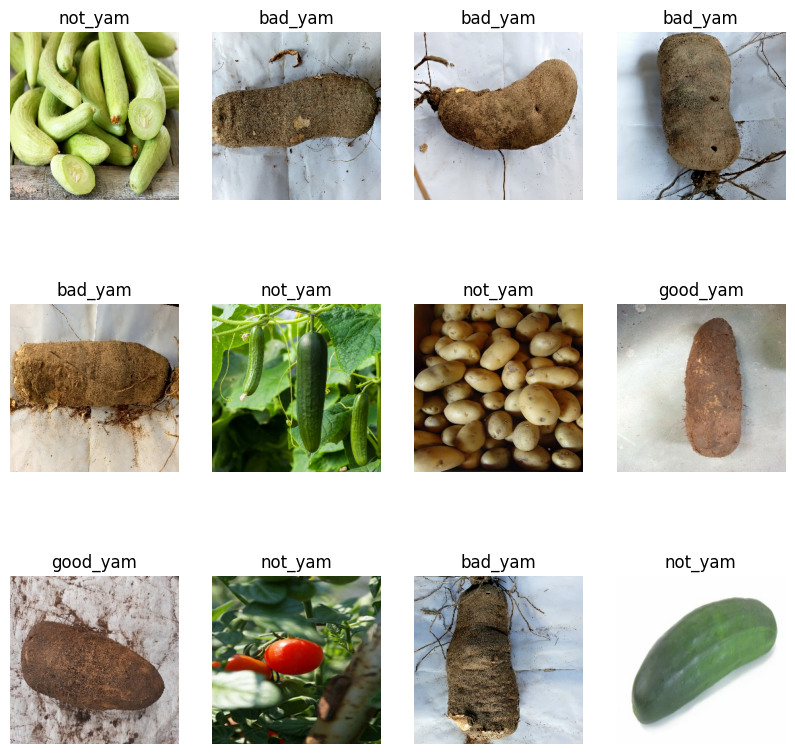

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch.numpy()[i]])
        plt.axis("off")

In [8]:
#Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  


In [10]:
data_augmrentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1)   
])

In [11]:
resize_and_rescale = tf.keras.Sequential([
    
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),

])

In [12]:
train_ds_augmented = train_ds.map(
  lambda x, y: (data_augmrentation(x, training=True), y))

In [13]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                         include_top=False,
                            weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    resize_and_rescale,       
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

C:\Users\Innov8 Hub\AppData\Local\Temp\ipykernel_14760\1418453723.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=3,
    restore_best_weights=True,
)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds_augmented,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    verbose=1
    )

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8036 - loss: 0.7024 - val_accuracy: 0.9375 - val_loss: 0.2195
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9561 - loss: 0.1340 - val_accuracy: 0.9688 - val_loss: 0.1017
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9742 - loss: 0.0657 - val_accuracy: 1.0000 - val_loss: 0.0632
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9871 - loss: 0.0473 - val_accuracy: 0.9688 - val_loss: 0.0631
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9897 - loss: 0.0450 - val_accuracy: 1.0000 - val_loss: 0.0545
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9922 - loss: 0.0306 - val_accuracy: 0.9688 - val_loss: 0.0490
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9871 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.0466
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9948 - loss: 0.0243 - val_accuracy: 0.9688 - val_loss:

In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print('\nTest accuracy:', test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 0.0150

Test accuracy: 1.0


In [18]:
#Export for FastAPI (TensorFlow 2.16.1 + Keras 3)
model_version = max([int(i) for i in os.listdir("../models")] + [0]) + 1
model.export(f"../models/{model_version}")
print(f"Model exported to ../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_161')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2471461867536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461869840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461870032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461868880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461868112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461869072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461870992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461870800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461869648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461871568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2471461870224: TensorSpec(shape=(),

In [19]:
model.save("../potatoes.h5")

In [20]:
model.save('my_model.keras')

In [21]:
model_path = f"../models/1"
#Load the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)

In [22]:
#Enable float16 quatization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [23]:
#convert to TFlite
tflite_model = converter.convert()

In [24]:
#save the TFLite model
with open("model_float16.tflite", "wb") as f:
    f.write(tflite_model)
print("Float16 TFlite model saved as model_float16.tflite")

Float16 TFlite model saved as model_float16.tflite
